In [1]:
import os
import random
import sys
import platform
import cv2

import pandas as pd
from sklearn.impute import SimpleImputer

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import seaborn as sns
from scipy.spatial.distance import euclidean
import math
from matplotlib.patches import Wedge, Ellipse, Polygon, Circle


def check_os():
    os = platform.system()

    if os == "Darwin":
        return "MacOS"
    elif os == "Linux":
        return "Linux"
    else:
        return "Unknown OS"

In [2]:
operating_system = check_os()

if operating_system == "MacOS":
    root_path = "/Users/johnny/Projects/"
elif operating_system == "Linux":
    root_path = "/home/johnny/Projects/"

In [3]:
def parse_annotation_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = []
    for line in lines:
        elements = line.split()
        id_ = elements[0]
        class_ = elements[1]
        x = int(elements[2])
        y = int(elements[3])
        width = int(elements[4])
        height = int(elements[5])
        occlusion = int(elements[6])
        # loitering = int(elements[7])

        # data.append([id_, class_, x, y, width, height, occlusion, loitering])
        data.append([id_, class_, x, y, width, height, occlusion])

    return data

In [4]:
if not os.path.exists(
    root_path + "/Master_Thesis_CV/datasets/annotations_original.csv"
):
    # Raíz de la carpeta de datos

    root_folder = os.path.join(root_path, "datasets/harbor-synthetic/annotations/")

    # Crear un dataframe vacío para almacenar todos los datos
    df = pd.DataFrame(columns=["id", "class", "x", "y", "width", "height", "occlusion"])
    # Crear una lista vacía para almacenar todos los dataframes
    dfs = []
    # Recorrer todas las carpetas y subcarpetas
    for folder, subfolders, files in tqdm(os.walk(root_folder)):
        # example '/Users/johnny/Projects/datasets/harbor-synthetic/annotations/20210220/clip_6_0248'
        temp_split = folder.split("/")
        clip_name = temp_split[-1]
        folder_name = temp_split[-2]
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(folder, file)
                data = parse_annotation_file(file_path)
                # frame_name = file.split('.')[0]
                frame_name = file.split("_")[-1].split(".")[0]
                # Añadir el nombre de la carpeta y el clip a cada fila
                for row in data:
                    row.insert(0, frame_name)
                    row.insert(0, clip_name)
                    row.insert(0, folder_name)

                # Añadir los datos a la lista de dataframes
                dfs.append(
                    pd.DataFrame(
                        data,
                        columns=[
                            "folder",
                            "clip",
                            "frame",
                            "id",
                            "class",
                            "x",
                            "y",
                            "width",
                            "height",
                            "occlusion",
                        ],
                    )
                )

    # Concatenar todos los dataframes
    df = pd.concat(dfs, ignore_index=True)

    # guardar el dataframe en un archivo csv
    # path actual de la carpeta
    path_actual = os.getcwd()

    df.to_csv(
        root_path + "Master_Thesis_CV/datasets/" + "annotations_original.csv",
        index=False,
    )

In [5]:
%whos

Variable                Type        Data/Info
---------------------------------------------
Circle                  type        <class 'matplotlib.patches.Circle'>
DBSCAN                  type        <class 'sklearn.cluster._dbscan.DBSCAN'>
Ellipse                 type        <class 'matplotlib.patches.Ellipse'>
IsolationForest         ABCMeta     <class 'sklearn.ensemble.<...>iforest.IsolationForest'>
KMeans                  ABCMeta     <class 'sklearn.cluster._kmeans.KMeans'>
Polygon                 type        <class 'matplotlib.patches.Polygon'>
SimpleImputer           type        <class 'sklearn.impute._base.SimpleImputer'>
StandardScaler          type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
Wedge                   type        <class 'matplotlib.patches.Wedge'>
check_os                function    <function check_os at 0x286da80e0>
cv2                     module      <module 'cv2' from '/User<...>ackages/cv2/__init__.py'>
euclidean               function    <

In [6]:
df = pd.read_csv(
    root_path + "/Master_Thesis_CV/datasets/annotations_original.csv"
).sort_values(by=["id", "frame"])

In [7]:
df.fillna(0, inplace=True)

In [8]:
df.to_csv(root_path + "Master_Thesis_CV/datasets/" + "annotations.csv", index=False)

In [9]:
# REMOVE TAMPERING
TAMPERING_VIDEOS = [
    "clip_23_1041",  # crane opertaing in front of camera
    "clip_36_1627",  # camera freezes, stutters
    "clip_37_1655",  # camera freezes, stutters
    "clip_28_1238",  # camera freezes, stutters
    "clip_40_2312",  # camera freezes, stutters
    "clip_13_0604",  # camera freezes, stutters
    "clip_14_0632",  # camera freezes, stutters
    "clip_20_0923",  # camera freezes, stutters
    "clip_21_0951",  # camera freezes, stutters
    "clip_26_1211",  # camera freezes, stutters
    "clip_27_1239",  # camera freezes, stutters
    "clip_28_1434",  # camera freezes, stutters
    "clip_23_1047",  # camera freezes, stutters
    "clip_9_0412",  # camera freezes, stutters
    # 20200516_clip_39_1726
    "20200526/clip_36_1617",  # faulty bounding boxes
    "20200526/clip_38_1713",  # faulty bounding boxes
    "20200614/clip_47_2057",  # faulty bounding boxes
    "20200521/clip_31_1359",  # faulty bounding boxes
    "20200614/clip_39_1727",  # faulty bounding boxes
    "20200601/clip_36_1614",
    "20210426/clip_32_1427",  # wrong annotations
    "20200526/clip_38_1713",  # wrong annotations
    "20200520_clip_46_2014",  # wrong annotations
]

WRONG_ANNOTATIONS = []

# remove tampering if clip is in TAMPERING_VIDEOS
df = df[~df["clip"].isin(TAMPERING_VIDEOS)]

# delete duplicates
df = df.drop_duplicates(
    subset=[
        "folder",
        "clip",
        "frame",
        "class",
        "x",
        "y",
        "width",
        "height",
        "occlusion",
    ],
    keep="first",
)

In [10]:
df

,folder,clip,frame,id,class,x,y,width,height,occlusion
5803680,20200514,clip_0_1331,14,0,bicycle,223,88,231,103,1
5803683,20200514,clip_0_1331,15,0,bicycle,202,89,211,104,1
5804201,20200514,clip_0_1331,18,0,bicycle,140,92,149,107,1
5804204,20200514,clip_0_1331,19,0,bicycle,123,94,130,107,1
5804244,20200514,clip_0_1331,20,0,bicycle,113,94,120,106,1
...,...,...,...,...,...,...,...,...,...,...
2061369,20210312,clip_41_2230,105,150294,human,178,128,184,145,1
2061378,20210312,clip_41_2230,105,150303,human,175,115,182,133,1
2061725,20210312,clip_41_2230,114,150305,human,183,91,189,104,1
2061383,20210312,clip_41_2230,105,150309,bicycle,175,124,182,132,1


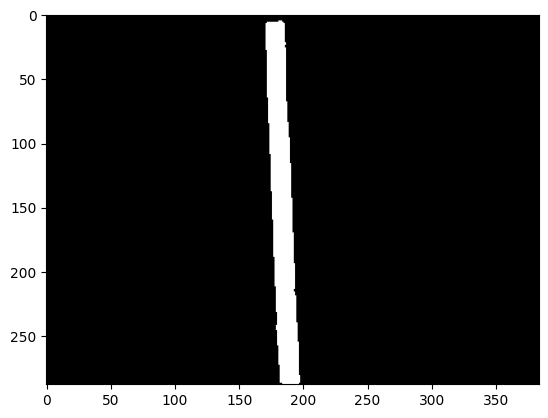

In [11]:
seg_img = cv2.imread("binary_mask.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(seg_img, cmap="gray")

In [12]:
df

,folder,clip,frame,id,class,x,y,width,height,occlusion
5803680,20200514,clip_0_1331,14,0,bicycle,223,88,231,103,1
5803683,20200514,clip_0_1331,15,0,bicycle,202,89,211,104,1
5804201,20200514,clip_0_1331,18,0,bicycle,140,92,149,107,1
5804204,20200514,clip_0_1331,19,0,bicycle,123,94,130,107,1
5804244,20200514,clip_0_1331,20,0,bicycle,113,94,120,106,1
...,...,...,...,...,...,...,...,...,...,...
2061369,20210312,clip_41_2230,105,150294,human,178,128,184,145,1
2061378,20210312,clip_41_2230,105,150303,human,175,115,182,133,1
2061725,20210312,clip_41_2230,114,150305,human,183,91,189,104,1
2061383,20210312,clip_41_2230,105,150309,bicycle,175,124,182,132,1


In [13]:
def is_in_white(x, y):
    """Return True if the point is in the white area of the image."""
    # Check if the coordinates are within the image dimensions
    if 0 <= y < seg_img.shape[0] and 0 <= x < seg_img.shape[1]:
        return seg_img[y, x] == 255  # 255 is the value for white in grayscale images
    else:
        return False


# Apply the function to the dataframe and create a boolean mask
mask = df.apply(lambda row: is_in_white(row["x"], row["y"]), axis=1)

# Use the mask to filter rows
df = df[~mask]

In [14]:
# how many True values are there?
mask.sum()

173129

In [15]:
df = df[df["class"] == "human"]
# exists nan?
df.isnull().values.any()

False

In [16]:
# filter all points (x,y) that are inside the mask
"""
import cv2
import pandas as pd

# Crear una función para verificar si un punto (x, y) está dentro de la parte blanca de la máscara
def is_in_white_region(x, y):
    return seg_img[y, x-1] == 255

# Filtrar los puntos que caen en la parte blanca de la máscara y eliminarlos del dataframe
indices_to_delete = []
for index, row in df.iterrows():
    x = int(row['x'])
    y = int(row['y'])
    if is_in_white_region(x, y):
        indices_to_delete.append(index)

df = df.drop(indices_to_delete)
# do an interpolation to substitute the occluded points

# Imprimir el dataframe resultante
print(df)

"""

"\nimport cv2\nimport pandas as pd\n\n# Crear una función para verificar si un punto (x, y) está dentro de la parte blanca de la máscara\ndef is_in_white_region(x, y):\n    return seg_img[y, x-1] == 255\n\n# Filtrar los puntos que caen en la parte blanca de la máscara y eliminarlos del dataframe\nindices_to_delete = []\nfor index, row in df.iterrows():\n    x = int(row['x'])\n    y = int(row['y'])\n    if is_in_white_region(x, y):\n        indices_to_delete.append(index)\n\ndf = df.drop(indices_to_delete)\n# do an interpolation to substitute the occluded points\n\n# Imprimir el dataframe resultante\nprint(df)\n\n"

In [17]:
df.to_csv(root_path + "Master_Thesis_CV/datasets/" + "annotations.csv", index=False)

# PERSPECTIVE MATRIX

In [18]:
MATRIX_PATH = root_path + '/Master_Thesis_CV/datasets/perspective_matrix.txt'

def transform_points(pts1):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')
    pts2 = cv2.perspectiveTransform(pts1, M)
    return pts2


def transform_df_points(df):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')

    df_pts = df[['x', 'y']]
    pts1 = df_pts.to_numpy(dtype=np.float32)
    pts1 = np.expand_dims(pts1, axis=0)

    pts2 = cv2.perspectiveTransform(pts1, M)
    df['x_transform'] = pts2[0, :, 0]
    df['y_transform'] = pts2[0, :, 1]
    return df

In [19]:
df = transform_df_points(df)

# HUMAN

In [20]:
df = df[df["class"] == "human"]
# exists nan?
df.isnull().values.any()

False

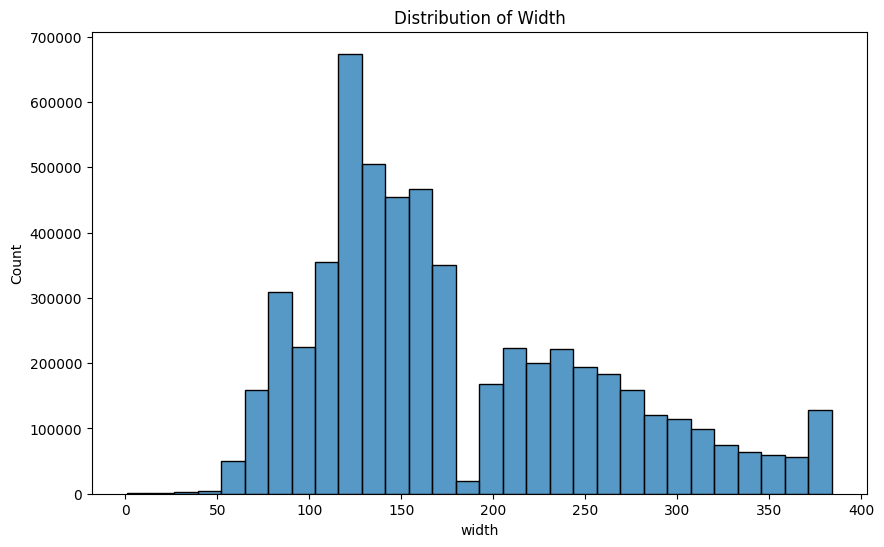

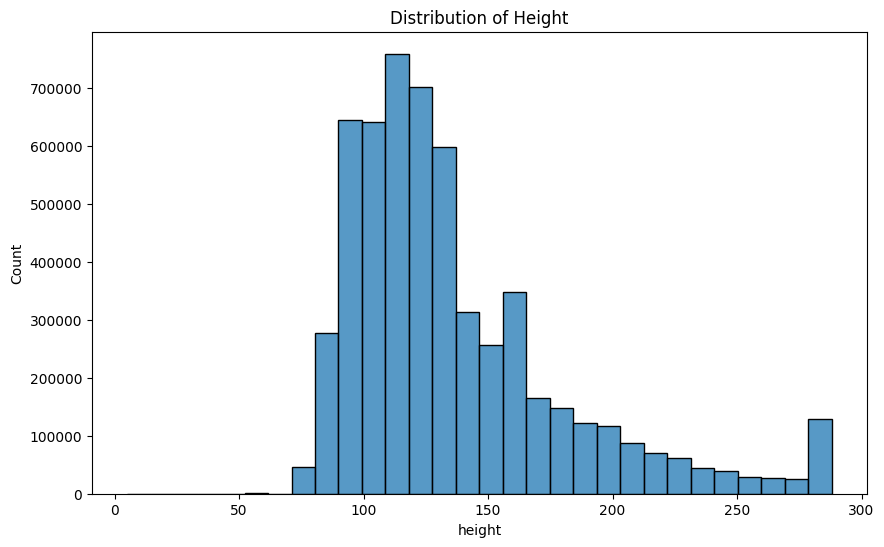

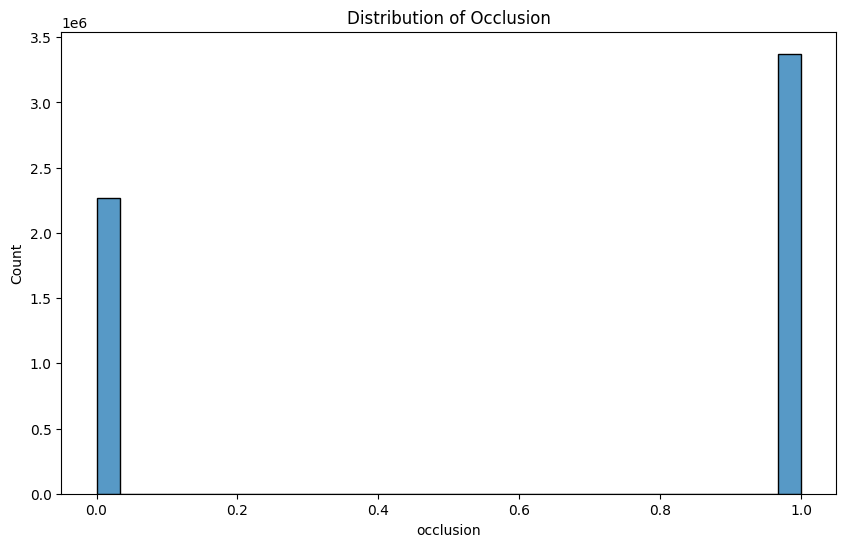

In [21]:
for col in ["width", "height", "occlusion"]:
    plt.figure(figsize=(10, 6))
    if col == "ratio":
        sns.histplot(df[col], bins=1, kde=True)
    else:
        sns.histplot(df[col], bins=30)
    plt.title(f"Distribution of {col.title()}")
    plt.show()

In [22]:
df.describe()

,folder,frame,id,x,y,width,height,occlusion,x_transform,y_transform
count,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06,5.643615e+06
mean,2.020595e+07,5.939384e+01,7.371742e+04,1.711295e+02,1.156456e+02,1.795224e+02,1.365124e+02,5.976875e-01,1.200745e+03,1.139183e+04
std,4.784411e+03,3.445642e+01,4.131283e+04,7.563432e+01,3.419046e+01,7.873707e+01,4.469836e+01,4.903644e-01,1.189213e+03,1.333271e+04
min,2.020051e+07,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,-3.052050e+05,-2.303991e+06
25%,2.020063e+07,3.000000e+01,3.861500e+04,1.140000e+02,9.200000e+01,1.200000e+02,1.060000e+02,0.000000e+00,9.091250e+02,5.653193e+03
50%,2.021012e+07,5.900000e+01,7.445100e+04,1.480000e+02,1.070000e+02,1.570000e+02,1.240000e+02,1.000000e+00,1.218236e+03,9.522272e+03
75%,2.021032e+07,8.900000e+01,1.096270e+05,2.240000e+02,1.290000e+02,2.340000e+02,1.550000e+02,1.000000e+00,1.522697e+03,1.438111e+04
max,2.021043e+07,1.190000e+02,1.502920e+05,3.840000e+02,2.870000e+02,3.840000e+02,2.880000e+02,1.000000e+00,2.000719e+06,1.944324e+07


              mean  median    std_dev
width   179.522362   157.0  78.737068
height  136.512449   124.0  44.698360
x       171.129496   148.0  75.634321
y       115.645645   107.0  34.190456


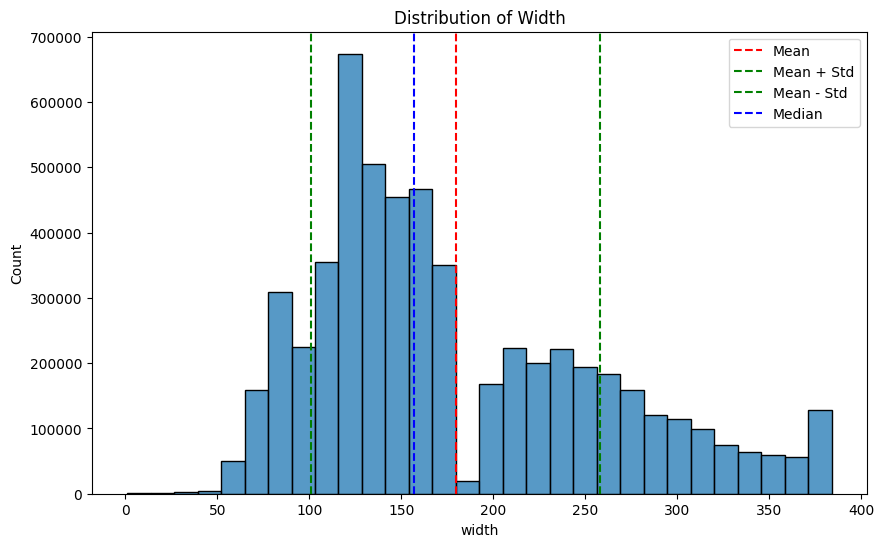

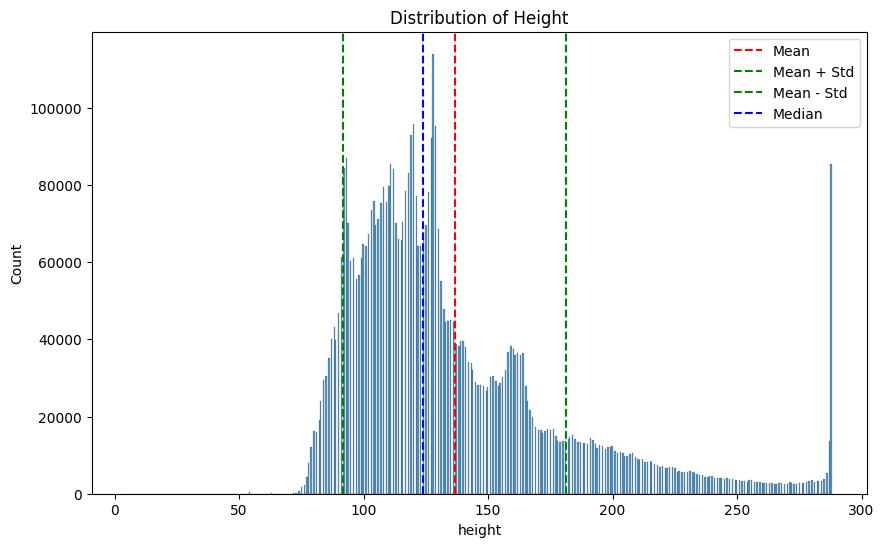

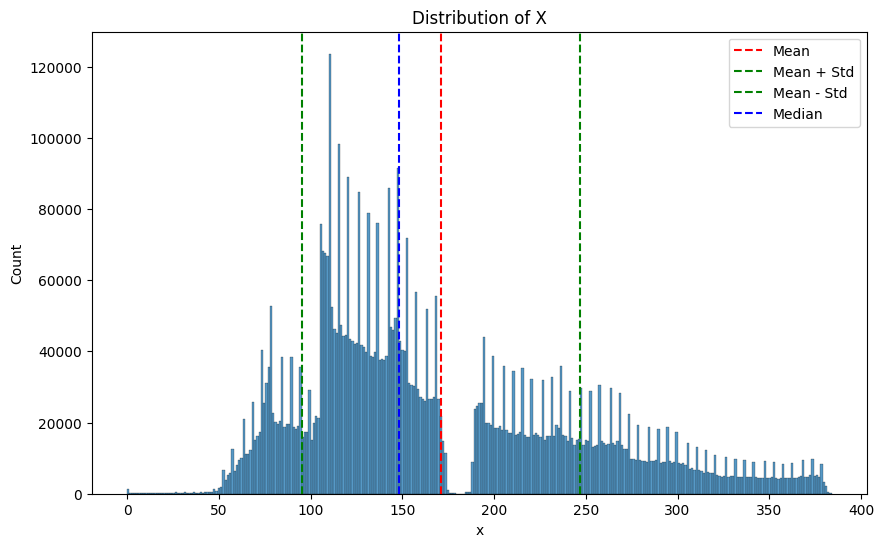

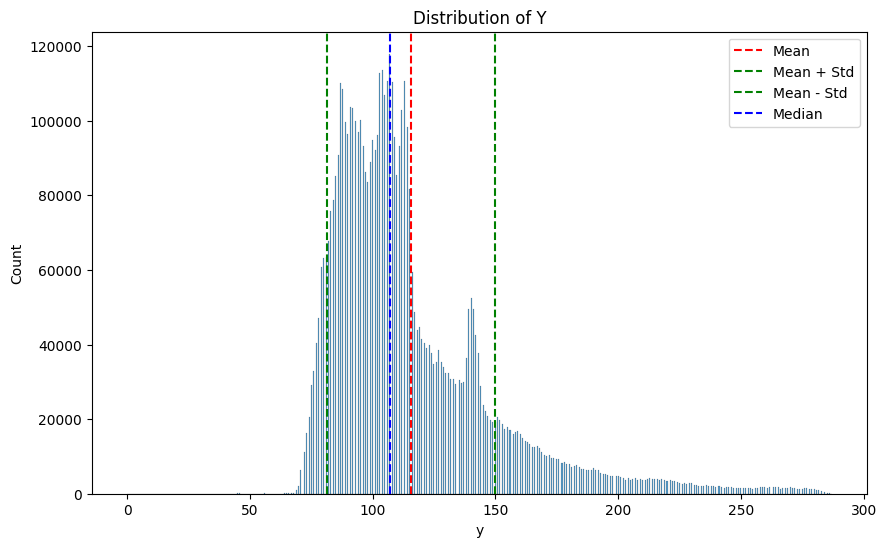

In [23]:
statistics = pd.DataFrame(
    {
        "mean": {
            "width": df["width"].mean(),
            "height": df["height"].mean(),
            # 'ratio': df['ratio'].mean(),
            "x": df["x"].mean(),
            "y": df["y"].mean(),
        },
        "median": {
            "width": df["width"].median(),
            "height": df["height"].median(),
            # 'ratio': df['ratio'].median(),
            "x": df["x"].median(),
            "y": df["y"].median(),
        },
        "std_dev": {
            "width": df["width"].std(),
            "height": df["height"].std(),
            # 'ratio': df['ratio'].std(),
            "x": df["x"].std(),
            "y": df["y"].std(),
        },
    }
)

print(statistics)

# plot for each width and height, x, y, ratio, histogram
for col in ["width", "height", "x", "y"]:
    plt.figure(figsize=(10, 6))
    if col in ["width", " height"]:
        sns.histplot(df[col], bins=30)
    else:
        sns.histplot(df[col])
        # center to 0.0

    # plot mean and std, mean + std, mean - std, median
    plt.axvline(df[col].mean(), color="red", linestyle="--")
    plt.axvline(df[col].mean() + df[col].std(), color="green", linestyle="--")
    plt.axvline(df[col].mean() - df[col].std(), color="green", linestyle="--")
    plt.axvline(df[col].median(), color="blue", linestyle="--")
    plt.title(f"Distribution of {col.title()}")
    plt.legend(["Mean", "Mean + Std", "Mean - Std", "Median"])
    plt.show()

In [24]:
# read the image
"""
import cv2

img = cv2.imread(
    root_path
    + "datasets/harbor-synthetic/LTD_Dataset/LTD_Dataset/Image_Dataset_25fps/20200514/clip_15_2004/image_0100.jpg"
)

# Convertimos la imagen de BGR a RGB (OpenCV usa BGR por defecto)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Filtramos el dataframe para el ID específico y lo ordenamos por el número de frame
df_id = df[df["id"] == 112]
df_id = df_id.sort_values(by=["frame"])
df_id = df_id.reset_index(drop=True)

# Trazamos la trayectoria en la imagen
for i in range(1, len(df_id)):
    start_point = (int(df_id.loc[i - 1, "x"]), int(df_id.loc[i - 1, "y"]))
    end_point = (int(df_id.loc[i, "x"]), int(df_id.loc[i, "y"]))
    img_rgb = cv2.line(img_rgb, start_point, end_point, (255, 0, 0), 2)

# Mostramos la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.show()
"""

'\nimport cv2\n\nimg = cv2.imread(\n    root_path\n    + "datasets/harbor-synthetic/LTD_Dataset/LTD_Dataset/Image_Dataset_25fps/20200514/clip_15_2004/image_0100.jpg"\n)\n\n# Convertimos la imagen de BGR a RGB (OpenCV usa BGR por defecto)\nimg_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n# Filtramos el dataframe para el ID específico y lo ordenamos por el número de frame\ndf_id = df[df["id"] == 112]\ndf_id = df_id.sort_values(by=["frame"])\ndf_id = df_id.reset_index(drop=True)\n\n# Trazamos la trayectoria en la imagen\nfor i in range(1, len(df_id)):\n    start_point = (int(df_id.loc[i - 1, "x"]), int(df_id.loc[i - 1, "y"]))\n    end_point = (int(df_id.loc[i, "x"]), int(df_id.loc[i, "y"]))\n    img_rgb = cv2.line(img_rgb, start_point, end_point, (255, 0, 0), 2)\n\n# Mostramos la imagen\nplt.figure(figsize=(10, 10))\nplt.imshow(img_rgb)\nplt.show()\n'

In [25]:
"""plt.figure(figsize=(10, 6))
# x and y axis more detailed
plt.xticks(np.arange(0, img.shape[1], 20))
plt.yticks(np.arange(0, img.shape[0], 20))
plt.imshow(img)"""

'plt.figure(figsize=(10, 6))\n# x and y axis more detailed\nplt.xticks(np.arange(0, img.shape[1], 20))\nplt.yticks(np.arange(0, img.shape[0], 20))\nplt.imshow(img)'

In [26]:
# plot
# read the image
"""
import cv2

img = cv2.imread(
    root_path
    + "datasets/harbor-synthetic/LTD_Dataset/LTD_Dataset/Image_Dataset_25fps/20200514/clip_0_1331/image_0000.jpg"
)
"""

'\nimport cv2\n\nimg = cv2.imread(\n    root_path\n    + "datasets/harbor-synthetic/LTD_Dataset/LTD_Dataset/Image_Dataset_25fps/20200514/clip_0_1331/image_0000.jpg"\n)\n'

In [27]:
# plot the image
"""
plt.figure(figsize=(10, 6))
plt.imshow(img)

from matplotlib.patches import Rectangle, Circle

# calculate center and dimensions for rectangle
rec_center = (df["x"].mean(), df["y"].mean())
rec_width = df["width"].mean()
rec_height = df["height"].mean()

# create rectangle patch
rectangle = Rectangle(
    (rec_center[0] - rec_width / 2, rec_center[1] - rec_height / 2),
    rec_width,
    rec_height,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)

# calculate center for circle
circle_center = (df["x"].mean(), df["y"].mean())

# create circle patch
circle = Circle(circle_center, 1, edgecolor="r", facecolor="none")

# plot the image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)

# Add the patch to the Axes
ax.add_patch(rectangle)
ax.add_patch(circle)

plt.show()
"""

'\nplt.figure(figsize=(10, 6))\nplt.imshow(img)\n\nfrom matplotlib.patches import Rectangle, Circle\n\n# calculate center and dimensions for rectangle\nrec_center = (df["x"].mean(), df["y"].mean())\nrec_width = df["width"].mean()\nrec_height = df["height"].mean()\n\n# create rectangle patch\nrectangle = Rectangle(\n    (rec_center[0] - rec_width / 2, rec_center[1] - rec_height / 2),\n    rec_width,\n    rec_height,\n    linewidth=1,\n    edgecolor="r",\n    facecolor="none",\n)\n\n# calculate center for circle\ncircle_center = (df["x"].mean(), df["y"].mean())\n\n# create circle patch\ncircle = Circle(circle_center, 1, edgecolor="r", facecolor="none")\n\n# plot the image\nfig, ax = plt.subplots(figsize=(10, 6))\nax.imshow(img)\n\n# Add the patch to the Axes\nax.add_patch(rectangle)\nax.add_patch(circle)\n\nplt.show()\n'

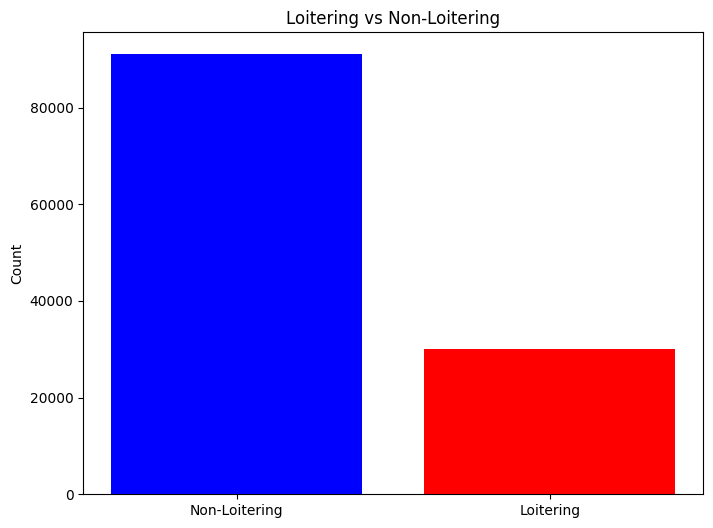

In [28]:
# Group the data by 'id' and calculate the standard deviation of 'x' and 'y'
grouped = df.groupby(["folder", "clip", "id"])[["x", "y"]].std()

# Detect loitering by checking if the standard deviation of 'x' and 'y' is below a certain threshold
# Lower standard deviation means that the object is not moving much
threshold = 10  # this value depends on your specific use case
grouped["loitering"] = (grouped["x"] < threshold) & (grouped["y"] < threshold)

# Reset index of 'grouped' DataFrame
grouped = grouped.reset_index()

# Print out the 'id's that were detected to be loitering
grouped[grouped["loitering"] == True]

import matplotlib.pyplot as plt

# Count the number of loitering and non-loitering instances
counts = grouped["loitering"].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(["Non-Loitering", "Loitering"], counts.values, color=["blue", "red"])
plt.ylabel("Count")
plt.title("Loitering vs Non-Loitering")
plt.show()

In [29]:
# show grouped folder = 20200514
grouped[
    (grouped["folder"] == 20210430)
    & (grouped["clip"] == "clip_53_2346")
    & (grouped["loitering"] == True)
]

,folder,clip,id,x,y,loitering
121043,20210430,clip_53_2346,143650,0.000000,0.000000,True
121044,20210430,clip_53_2346,143651,0.000000,0.000000,True
121045,20210430,clip_53_2346,143652,0.000000,0.000000,True
121046,20210430,clip_53_2346,143653,2.631366,0.608932,True
121047,20210430,clip_53_2346,143654,4.272174,0.550973,True


In [30]:
df.head()

,folder,clip,frame,id,class,x,y,width,height,occlusion,x_transform,y_transform
5803877,20200514,clip_0_1331,49,3,human,108,95,113,111,1,1021.293152,14766.603516
5804000,20200514,clip_0_1331,50,3,human,109,96,114,112,0,1003.861755,14300.315430
5804074,20200514,clip_0_1331,51,3,human,110,96,115,113,1,1015.966675,14253.065430
5803991,20200514,clip_0_1331,52,3,human,111,96,116,113,0,1027.992065,14206.126953
5803955,20200514,clip_0_1331,53,3,human,112,96,118,113,0,1039.938477,14159.495117


In [31]:
def calculate_distance(group):
    coords = group[["x", "y"]].values
    distance = sum(euclidean(coords[i - 1], coords[i]) for i in range(1, len(coords)))
    return distance


def calculate_area(group):
    x_min = group["x"].min()
    x_max = group["x"].max()
    y_min = group["y"].min()
    y_max = group["y"].max()
    return (x_max - x_min) * (y_max - y_min)


def calculate_average_speed(group):
    coords = group[["x", "y"]].values
    total_distance = 0
    for i in range(1, len(coords)):
        distance = euclidean(coords[i - 1], coords[i])
        total_distance += distance
    division = len(coords) - 1
    if division == 0:
        return 0
    else:
        average_speed = total_distance / 120
        return average_speed


from scipy.spatial import ConvexHull
from matplotlib import patches


def get_moving_area(tracklet):
    points = np.array(tracklet[["x", "y"]])
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    return polygon_points


def get_moving_area_value(tracklet):
    points = np.array(tracklet[["x", "y"]])
    hull = ConvexHull(points)
    return hull.volume


def calculate_changes_in_direction(direction):
    change_in_direction = direction.diff().abs()
    change_in_direction.loc[change_in_direction < np.pi] *= -1
    change_in_direction.loc[change_in_direction > np.pi] = (
        change_in_direction - 2 * np.pi
    ).abs()
    return change_in_direction


def check_passing_initial_point(row, initial_locations, threshold=10):
    """Check if a person passes near the initial point.

    Arguments:
    row -- DataFrame row
    initial_locations -- DataFrame with the initial locations
    threshold -- Distance considered as "near" the initial point. Default: 10.
    """
    # Get initial location for this id and clip
    initial_location = initial_locations.loc[(row["folder"], row["clip"], row["id"])]
    # Calculate distance from current location to initial location
    distance_to_initial = np.sqrt(
        (row["x"] - initial_location["x"]) ** 2
        + (row["y"] - initial_location["y"]) ** 2
    )
    # Return True if distance is less than threshold, False otherwise
    return distance_to_initial < threshold


def calculate_direction_change_180(series):
    # Calculate derivative of series
    derivative = np.diff(series)
    # Changes in sign in derivative (close to pi - considering a small error due to numerical calculations)
    changes = np.where(
        (np.diff(np.sign(derivative)) != 0) & (np.abs(derivative[1:]) > np.pi - 0.01)
    )[0]
    return len(changes)

## 1. Create equations

In [32]:
# convert to int id column
df['id'] = df['id'].astype(int)

In [33]:
folders_to_keep = [
    20200514, 20200515, 20200516, 20200517, 20200518, 20200519, 20200520, 
    20200521, 20200522, 20200523, 20200524, 20200525, 20200526, 20200830, 
    20200831, 20200901, 20210108, 20210109, 20210110, 20210228, 20210301, 
    20210302, 20210303, 20210304, 20210305, 20210411, 20210412, 20210413, 
    20210414, 20210415, 20210416
]

print(len(df))
df = df[df['folder'].isin(folders_to_keep)]
print(len(df))

5643615
874936


In [34]:
# save the new dataset
df.to_csv(root_path + '/Master_Thesis_CV/datasets/folders.csv', index=False)


In [35]:
ids = pd.read_csv(root_path + 'Master_Thesis_CV/datasets/ids_final_combined.csv', header=None)
len(ids)

3990

In [36]:
ids

,0
0,64994.0
1,66923.0
2,67344.0
3,67395.0
4,68464.0
...,...
3985,4438.0
3986,4439.0
3987,4440.0
3988,4457.0


In [37]:
import numpy as np
import pandas as pd

ids = pd.read_csv(root_path + 'Master_Thesis_CV/datasets/ids_final_combined.csv', header=None)
ids[0] = ids[0].astype(int)
ids = ids[0].values.tolist()

# save the ids
np.save(root_path + 'Master_Thesis_CV/datasets/ids.npy', ids)

# save csv from ids
ids_df = pd.DataFrame(ids)
ids_df.to_csv(root_path + 'Master_Thesis_CV/datasets/ids.csv', index=False, header=False)

ids_ = pd.read_csv(root_path + 'Master_Thesis_CV/datasets/ids.csv', header=None)
# ids_ to list
ids_ = ids_[0].values.tolist()

# create column in annotations
df['loitering'] = 0

# Use isin to check if each id in annotations is in ids_
df['loitering'] = df['id'].isin(ids_).astype(int)

# same by deleting the ids that are not in ids_
GT_ANNOTATIONS = df[df['id'].isin(ids_)]

GT_ANNOTATIONS.to_csv(root_path + 'Master_Thesis_CV/datasets/annotations_gt.csv', index=False)

# save annotations
df.to_csv(root_path + 'Master_Thesis_CV/datasets/annotations_loitering.csv', index=False)

In [38]:
len(df)

874936

In [39]:
df[df.loitering == 1]

,folder,clip,frame,id,class,x,y,width,height,occlusion,x_transform,y_transform,loitering
5803678,20200514,clip_0_1331,0,9,human,77,109,86,119,1,363.626465,11156.555664,1
5803686,20200514,clip_0_1331,1,9,human,77,109,86,119,0,363.626465,11156.555664,1
5803672,20200514,clip_0_1331,2,9,human,77,109,85,119,0,363.626465,11156.555664,1
5803670,20200514,clip_0_1331,3,9,human,77,109,85,119,0,363.626465,11156.555664,1
5803658,20200514,clip_0_1331,4,9,human,77,109,85,119,0,363.626465,11156.555664,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905720,20200518,clip_50_2238,64,144884,human,236,187,252,240,0,692.014893,2181.884033,1
2905682,20200518,clip_50_2238,65,144884,human,236,187,252,240,0,692.014893,2181.884033,1
2905624,20200518,clip_50_2238,66,144884,human,236,187,253,241,1,692.014893,2181.884033,1
2905670,20200518,clip_50_2238,67,144884,human,235,188,252,241,0,682.209412,2149.463867,1


In [40]:
grouped_by_id = df.groupby('id').size()

In [41]:
ids_with_less_than_10_frames = grouped_by_id[grouped_by_id < 15]

In [42]:
ids_with_less_than_10_frames

id
11         6
12         5
30         1
33         7
34         6
          ..
144662    12
144884     7
144994     1
145571    12
145575     7
Length: 3925, dtype: int64

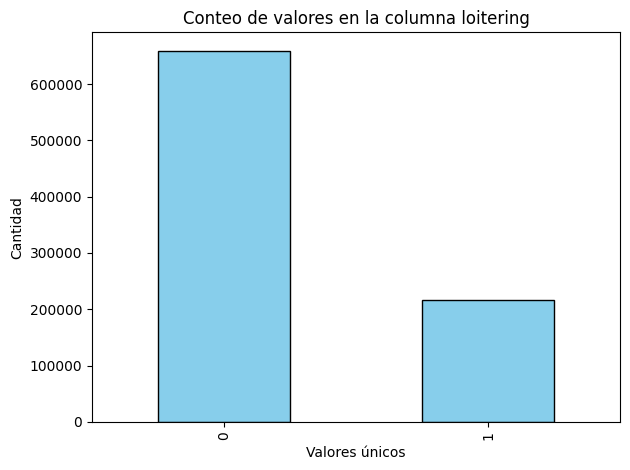

In [43]:
value_counts_1 = df['loitering'].value_counts()

# Bar plot
value_counts_1.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Conteo de valores en la columna loitering')
plt.xlabel('Valores únicos')
plt.ylabel('Cantidad') # Rotación de las etiquetas del eje x para mejor visualización
plt.tight_layout()  # Asegurarse de que todo se visualice correctamente
plt.show()

In [44]:
df.loc[df['id'].isin(ids_with_less_than_10_frames.index), 'loitering'] = 0

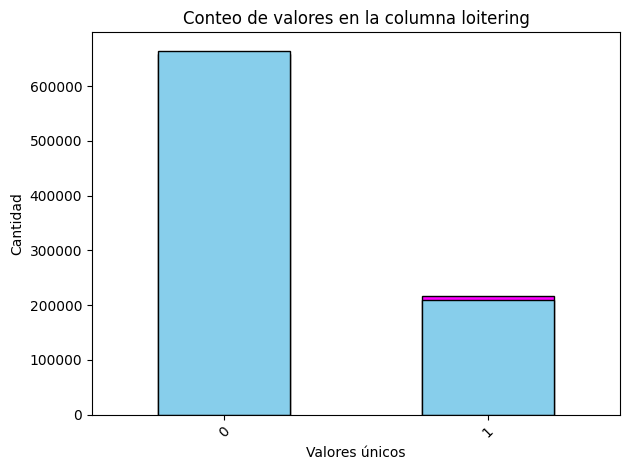

In [45]:
value_counts = df['loitering'].value_counts()

# Bar plot
value_counts_1.plot(kind='bar', color='magenta', edgecolor='black')
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Conteo de valores en la columna loitering')
plt.xlabel('Valores únicos')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para mejor visualización
plt.tight_layout()  # Asegurarse de que todo se visualice correctamente
plt.show()

In [46]:
coord_dict = {}

# df = df[df.folder < 20200526]
# Recorre cada ID único en el DataFrame
folders_to_keep = [
    20200514, 20200515, 20200516, 20200517, 20200518, 20200519, 20200520, 
    20200521, 20200522, 20200523, 20200524, 20200525, 20200526, 20200830, 
    20200831, 20200901, 20210108, 20210109, 20210110, 20210228, 20210301, 
    20210302, 20210303, 20210304, 20210305, 20210411, 20210412, 20210413, 
    20210414, 20210415, 20210416
]

# Filtrar el DataFrame basado en la lista
df = df[df['folder'].isin(folders_to_keep)]

for id in tqdm(df["id"].unique()):
    # Filtra el DataFrame para solo ese ID
    df_id = df[df["id"] == id]
    # Crea una lista de tuplas de las coordenadas x, y para ese ID
    coord_list = list(zip(df_id["x_transform"], df_id["y_transform"]))
    # Agrega esta lista al diccionario con la clave siendo el ID
    coord_dict[id] = coord_list

100%|██████████| 19737/19737 [00:06<00:00, 3008.68it/s]


In [47]:
# save coord_dict to file
import pickle

with open(root_path + "Master_Thesis_CV/datasets/" + "coord_dict.pkl", "wb") as handle:
    pickle.dump(coord_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# show absolut max x and max y
max_x = df["x"].max()
max_y = df["y"].max()
print(max_x, max_y)

383 286


In [51]:
max_x = df["x_transform"].max()
max_y = df["y_transform"].max()
print(max_x, max_y)

# which row has the max x and y
df[df["x_transform"] == max_x]
df[df["y_transform"] == max_y]



2000719.0 19443238.0


,folder,clip,frame,id,class,x,y,width,height,occlusion,x_transform,y_transform,loitering
5925996,20200525,clip_30_1327,102,7814,human,111,53,117,68,1,1427355.375,19443238.0,0


## 2. Calculate angles

In [ ]:
# Function to calculate angle change
"""
def calculate_angle_change(v_t, v_m, theta):
    dot_product = np.dot(v_t, v_m)
    mag_v_t = np.linalg.norm(v_t)
    mag_v_m = np.linalg.norm(v_m)
    angle_rad = np.arccos(dot_product / (mag_v_t * mag_v_m))
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Process the coordinate dictionary
theta = 50
feature_points_dict = {}
for id, positions in coord_dict.items():
    feature_points = []
    if len(positions) > 1:
        direction_vectors = np.diff(positions, axis=0)
        v_m = direction_vectors[0]
        for v_t in direction_vectors[1:]:
            angle_change = calculate_angle_change(v_t, v_m, theta)
            if angle_change > theta:
                feature_points.append(v_t)
                v_m = v_t
        feature_points_dict[id] = feature_points
    else:
        print(f"Skipping id {id} because it has less than two positions.")
"""

In [ ]:
"""import math

# theta = math.radians()  # Convertir grados a radianes
theta = 80  # Definir el umbral de ángulo
feature_vector_threshold = 4  # Definir el límite para los vectores de características
T0 = 60  # Escoger un valor para T0, este valor es un ejemplo
S_threshold = 10  # Escoger un valor para S_threshold, este valor es un ejemplo
loitering_ids = []  # Lista para almacenar los IDs de los peatones que están merodeando


def calculate_vector_angle(path):
    v_ts = np.diff(path, axis=0)  # Calcular los vectores de dirección del objetivo
    feature_points = []
    if v_ts.size != 0:  # Verificar que v_ts no esté vacío
        v_m = v_ts[0]
        for v_t in v_ts[1:]:
            cos_angle = np.dot(v_t, v_m) / (np.linalg.norm(v_t) * np.linalg.norm(v_m))
            angle = np.degrees(np.arccos(cos_angle))
            if angle > theta:
                feature_points.append(tuple(v_t))
                v_m = v_t  # Actualizar el vector de dirección v_m
    return feature_points


def rectangle_loitering_detection(coordinates, T0, S_threshold):
    for i in range(T0, len(coordinates)):
        P_i = coordinates[i]
        P_i_T = coordinates[i - T0]
        Dx = abs(P_i[0] - P_i_T[0])
        Dy = abs(P_i[1] - P_i_T[1])
        S = Dx * Dy
        if S < S_threshold:
            return True
    return False


# Definir la función para la detección de loitering elíptico
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares


def ellipse_loitering_detection(coordinates, T0, S_threshold):
    if len(coordinates) <= T0:
        return False

    for i in range(T0, len(coordinates)):
        points = coordinates[i - T0 : i]
        if len(set(points[:, 0])) > 1 and len(set(points[:, 1])) > 1:
            try:  # Comprobar si todas las coordenadas x son iguales
                hull = ConvexHull(points)
                hull_points = coordinates[hull.vertices]

                if len(hull_points) < 6:
                    continue

                def ellipse_error(params):
                    A, B, C, D, E, F = params
                    x, y = hull_points[:, 0], hull_points[:, 1]
                    return A * x**2 + B * x * y + C * y**2 + D * x + E * y + F

                initial_guess = [1, 1, 1, 1, 1, 1]
                result = least_squares(ellipse_error, initial_guess)
                A, B, C, D, E, F = result.x

                S = np.pi * A * C
                if S < S_threshold:
                    return True
            except:
                return False
        else:
            continue

    return False


def sector_loitering_detection(coordinates, T0, S_threshold):
    P0 = coordinates[0]
    for i in range(T0, len(coordinates)):
        Pi = coordinates[i]
        Di = np.sqrt(
            (Pi[0] - P0[0]) ** 2 + (Pi[1] - P0[1]) ** 2
        )  # Calcular la distancia entre Pi y P0
        alpha = np.arctan2(
            Pi[1] - P0[1], Pi[0] - P0[0]
        )  # Calcular el ángulo en radianes
        S = 0.5 * Di**2 * alpha  # Calcular el tamaño del área de actividad
        if S < S_threshold:
            return True
    return False


for ID, coordinates in coord_dict.items():
    coords_array = np.array(coordinates)
    feature_points = calculate_vector_angle(coords_array)
    if len(feature_points) > feature_vector_threshold:
        print(
            f"For pedestrian {ID}, number of feature vectors: {len(feature_points)}. "
            "Possible loitering based on the features in the activity zone."
        )
        # Proceder con la detección de loitering
        if rectangle_loitering_detection(coords_array, T0, S_threshold):
            print(f"Rectangular loitering detected for pedestrian {ID}")
            loitering_ids.append(ID)
        if ellipse_loitering_detection(coords_array, T0, S_threshold):
            print(f"Elliptical loitering detected for pedestrian {ID}")
            # loitering_ids.append(ID)
        if sector_loitering_detection(coords_array, T0, S_threshold):
            print(f"Sector loitering detected for pedestrian {ID}")
            loitering_ids.append(ID)
    else:
        print(
            f"For pedestrian {ID}, number of feature vectors: {len(feature_points)}. "
            "No loitering detected based on the features in the activity zone."
        )

print("IDs de peatones en loitering: ", loitering_ids)"""

# Savitzky-Golay 

In [ ]:
from scipy.signal import savgol_filter
import numpy as np

# Default Savitzky-Golay parameters
window_length = 10
poly_order = 3

# Dictionary to store smoothed coordinates
smoothed_coord_dict = {}

# Apply Savitzky-Golay filter to each ID in the dictionary
for id, coords in tqdm(coord_dict.items(), leave=True, position=0):
    if len(coords) < window_length:
        # Skip if not enough data points to apply the filter
        smoothed_coord_dict[id] = coords
        continue
    
    x_coords = np.array([x for x, y in coords])
    y_coords = np.array([y for x, y in coords])
    
    x_smoothed = savgol_filter(x_coords, window_length, poly_order)
    y_smoothed = savgol_filter(y_coords, window_length, poly_order)
    
    smoothed_coords = np.array(list(zip(x_smoothed, y_smoothed)))
    smoothed_coord_dict[id] = smoothed_coords

In [ ]:
# save coord_dict to file
import pickle

with open(
    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth_v2.pkl", "wb"
) as handle:
    pickle.dump(smoothed_coord_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# RDP

In [ ]:
from rdp import rdp

# do it for coords and coords_transform
# Recorre cada ID único en el DataFrame
coord_dict_simplified = {}
for ID, path in tqdm(coord_dict.items(), leave=True, position=0):
    # Simplifica la trayectoria usando el algoritmo RDP
    path = np.array(path)
    path = rdp(path, epsilon=30)
    # Agrega la trayectoria simplificada al diccionario
    coord_dict_simplified[ID] = path

In [ ]:
# save coord_dict to file
import pickle

with open(
    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth.pkl", "wb"
) as handle:
    pickle.dump(coord_dict_simplified, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df.to_csv(root_path + "Master_Thesis_CV/datasets/" + 'final_dataset.csv', index=False)

In [ ]:
id_112 = coord_dict[112]
id_112 = np.array(id_112)
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
id_112 = coord_dict_simplified[112]
# id_112 = rdp(id_112, epsilon=30)
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
id_112 = smoothed_coord_dict[112]
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil

directories = [
    "plots/trajectory",
    "plots/rectangle",
    "plots/ellipse",
    "plots/sector",
    "plots/closed_areas",
    "plots/no_motion",
    "plots/second_derivative",
]

# Delete and recreate each directory
for directory in directories:
    shutil.rmtree(directory, ignore_errors=True)  # Delete the directory if it exists
    os.makedirs(directory, exist_ok=True)  # Create the directory

import numpy as np
import matplotlib.pyplot as plt


def calculate_curvature(coordinates):
    # Convert the list of coordinates to a numpy array
    coordinates = np.array(coordinates)

    # Ensure there are at least three points
    if len(coordinates) < 3:
        return None

    # Calculate the gradient of the x and y coordinates
    dx = np.gradient(coordinates[:, 0])
    dy = np.gradient(coordinates[:, 1])

    # Calculate the second derivatives of the x and y coordinates
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # Calculate the curvature
    curvature = np.abs(ddx * dy - dx * ddy) / np.power(dx * dx + dy * dy, 1.5)

    return curvature


def find_inflection_points(curvature, threshold):
    # Find points where the change in curvature is greater than the threshold
    inflection_points = np.where(np.abs(np.gradient(curvature)) > threshold)[0]

    return inflection_points


def plot_trajectory_with_inflections(coordinates, inflection_points, ID):
    # Plot the trajectory
    plt.plot(coordinates[:, 0], coordinates[:, 1], label="Trajectory")

    # Plot the inflection points
    plt.plot(
        coordinates[inflection_points, 0],
        coordinates[inflection_points, 1],
        "ro",
        label="Inflection points",
    )

    # Add labels and title
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Trajectory with inflection points for ID: {ID}")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.xlim([0, 384])
    plt.ylim([288, 0])
    # Save the figure and close the plot
    plt.savefig(f"plots/second_derivative/{ID}_second_derivative.png")
    plt.close()


# Loop over all trajectories
threshold = 0.002  # Adjust this value to change the minimum curvature change for an inflection point
for id, coordinates in coord_dict_simplified.items():
    coordinates = np.array(coordinates)

    # Calculate the curvature
    curvature = calculate_curvature(coordinates)

    # Skip if the trajectory has fewer than 3 points
    if curvature is None:
        continue

    # Find the inflection points
    inflection_points = find_inflection_points(curvature, threshold)

    # Plot the trajectory with inflection points
    plot_trajectory_with_inflections(coordinates, inflection_points, id)

In [ ]:
from scipy.spatial import ConvexHull
from scipy.spatial import distance


def compute_convex_hull_area(points):
    if len(points) < 3:  # Cannot compute a ConvexHull with fewer than 3 points
        return 0.0  # Return an area of 0.0 for empty or insufficient inputs

    if len(points) == 3:  # If there are only three points
        if (
            np.all(points[0] == points[1])
            or np.all(points[0] == points[2])
            or np.all(points[1] == points[2])
        ):  # If any two points are the same
            return 0.0  # Return an area of 0.0

    # Compute the pairwise distances between points
    dist_matrix = distance.cdist(points, points)

    # If the maximum distance between any two points is zero, all points are the same
    if np.max(dist_matrix) == 0:
        return 0.0  # Return an area of 0.0

    # Compute the pairwise differences between points
    deltas = np.diff(points, axis=0)

    # If all the deltas are multiples of each other, the points are collinear
    ratios = deltas / deltas[0]
    if np.allclose(ratios, ratios[0]):
        return 0.0  # Return an area of 0.0 for collinear inputs

    # Otherwise, compute and return the ConvexHull area
    hull = ConvexHull(points)
    return hull.area


def detect_loitering(convex_hull_area, loitering_threshold):
    if convex_hull_area < loitering_threshold:
        return True  # Loitering detected
    else:
        return False  # No loitering detected


from scipy.spatial import Delaunay


def plot_trajectory_with_inflections_and_convex_hull(
    coordinates, inflection_points, convex_hull_points, id
):
    # Plot the trajectory
    plt.plot(coordinates[:, 0], coordinates[:, 1], label="Trajectory")

    # Plot the inflection points
    plt.plot(
        coordinates[inflection_points, 0],
        coordinates[inflection_points, 1],
        "ro",
        label="Inflection points",
    )

    # Compute the convex hull area
    convex_hull_area = compute_convex_hull_area(convex_hull_points)

    # If the area is larger than zero, the points are sufficient to form a 2D polygon
    if convex_hull_area > 0:
        # Compute the Delaunay triangulation of the convex hull points
        tri = Delaunay(convex_hull_points)

        # Plot the convex hull
        plt.triplot(
            convex_hull_points[:, 0],
            convex_hull_points[:, 1],
            tri.simplices,
            label="Convex Hull",
        )

    # Add labels and title
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Trajectory with inflection points for ID: {id}")
    plt.gca().invert_yaxis()
    plt.xlim([0, 384])
    plt.ylim([288, 0])
    plt.legend()

    # Save the figure and close the plot
    plt.savefig(f"plots/trajectory_with_inflections_and_convex_hull/{id}.png")
    plt.close()


# Loop over all trajectories
loitering_threshold = (
    1.0  # Adjust this value based on your specific definition of loitering
)
for id, coordinates in coord_dict_simplified.items():
    coordinates = np.array(coordinates)

    # Calculate the curvature
    curvature = calculate_curvature(coordinates)

    # Skip if the trajectory has fewer than 3 points
    if curvature is None:
        continue

    # Find the inflection points
    inflection_points = find_inflection_points(curvature, threshold)

    # Compute the convex hull area around the inflection points
    convex_hull_area = compute_convex_hull_area(coordinates[inflection_points])

    # Detect loitering
    is_loitering = detect_loitering(convex_hull_area, loitering_threshold)
    print(f"ID: {id}, Loitering detected: {is_loitering}")

    # Plot the trajectory with inflection points and trace area convex hull
    plot_trajectory_with_inflections_and_convex_hull(
        coordinates, inflection_points, coordinates[inflection_points], id
    )

In [ ]:
import math
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np
import shutil


(
    rectangle_loitering,
    ellipse_loitering,
    sector_loitering,
    closed_areas_loitering,
    no_motion_loitering,
) = (
    [],
    [],
    [],
    [],
    [],
)  # Lista para almacenar los IDs de los peatones que están merodeando

import shutil

# List of directories
directories = [
    "plots/trajectory",
    "plots/rectangle",
    "plots/ellipse",
    "plots/sector",
    "plots/closed_areas",
    "plots/no_motion",
    "plots/second_derivative",
]

# Delete and recreate each directory
for directory in directories:
    shutil.rmtree(directory, ignore_errors=True)  # Delete the directory if it exists
    os.makedirs(directory, exist_ok=True)  # Create the directory


def calculate_vector_angle(path):
    v_ts = np.diff(path, axis=0)  # Calculate the target direction vectors
    feature_points = []
    last_change_index = None
    last_time_step = None
    if v_ts.size != 0:  # Check that v_ts is not empty
        v_m = v_ts[0]
        for i, v_t in enumerate(v_ts[1:], start=1):
            cos_angle = np.dot(v_t, v_m) / (np.linalg.norm(v_t) * np.linalg.norm(v_m))
            angle = np.degrees(np.arccos(cos_angle))
            if angle > theta:
                feature_points.append(tuple(v_t))
                v_m = v_t  # Update the direction vector v_m
                last_change_index = i  # Record the index of the last significant change
            else:
                last_time_step = i
    return feature_points, last_change_index, last_time_step


# Function to detect and plot rectangle loitering
def rectangle_loitering_detection(P, T0, S_threshold, ID):
    # Initialize variables
    D_x_max, D_x_min, D_y_max, D_y_min = -np.inf, np.inf, -np.inf, np.inf
    loitering_detected = False

    for i in range(T0, len(P)):
        # Calculate the distance between P_i and P_{i-T}
        dx = P[i][0] - P[i - T0][0]
        dy = P[i][1] - P[i - T0][1]

        # Update D_x and D_y
        D_x_max = max(D_x_max, dx)
        D_x_min = min(D_x_min, dx)
        D_y_max = max(D_y_max, dy)
        D_y_min = min(D_y_min, dy)

        # Calculate the size of activity area
        S = abs(D_x_max - D_x_min) * abs(D_y_max - D_y_min)

        # Check if the area is less than the threshold
        if S < S_threshold:
            loitering_detected = True
            break

    if loitering_detected:
        fig, ax = plt.subplots()
        ax.plot(P[:, 0], P[:, 1], "b")  # Plot the trajectory
        # Plot the rectangle where loitering is detected
        rect = plt.Rectangle(
            (D_x_min, D_y_min),
            D_x_max - D_x_min,
            D_y_max - D_y_min,
            fill=False,
            edgecolor="r",
            linewidth=1,
        )
        ax.add_patch(rect)
        ax.set_title(f"Rectangle Loitering Detected ID: {ID}")
        ax.invert_yaxis()
        plt.xlim([0, 384])
        plt.ylim([288, 0])
        plt.savefig(f"plots/rectangle/{ID}_rectangle.png")
        plt.close()

    return loitering_detected


def ellipse_loitering_detection(coordinates, T0, S_threshold, ID):
    if len(coordinates) <= T0:
        return False

    for i in range(T0, len(coordinates)):
        points = coordinates[i:]
        if len(set(points[:, 0])) > 1 and len(set(points[:, 1])) > 1:
            if len(points) >= 3:
                try:
                    hull = ConvexHull(points)
                    hull_points = coordinates[hull.vertices]

                    if len(hull_points) < 6:
                        continue

                    center = np.mean(hull_points, axis=0)

                    polar_coords = np.array(
                        [
                            (
                                np.degrees(
                                    np.arctan2(
                                        point[1] - center[1], point[0] - center[0]
                                    )
                                ),
                                np.linalg.norm(point - center),
                            )
                            for point in hull_points
                        ]
                    )

                    sorted_indices = np.lexsort(
                        (polar_coords[:, 1], -polar_coords[:, 0])
                    )
                    sorted_points = hull_points[sorted_indices]

                    for t in range(len(sorted_points) - 5):
                        selected_points = sorted_points[t : t + 6]

                        def ellipse_error(params):
                            A, B, C, D, E, F = params
                            x, y = selected_points[:, 0], selected_points[:, 1]
                            return (
                                A * x**2 + B * x * y + C * y**2 + D * x + E * y + F
                            ) ** 2

                        initial_guess = [1, 1, 1, 1, 1, 1]
                        result = least_squares(ellipse_error, initial_guess)
                        A, B, C, D, E, F = result.x

                        S = np.pi * A * C
                        print("Ellipse area", S)

                        if S > S_threshold:
                            fig, ax = plt.subplots()
                            ax.plot(coordinates[:, 0], coordinates[:, 1], "b")
                            for simplex in hull.simplices:
                                plt.plot(
                                    points[simplex, 0], points[simplex, 1], "r-"
                                )  # plot the convex hull
                            ellipse = Ellipse(
                                (D / (-2 * A), E / (-2 * C)),
                                width=2 * abs(S / (np.pi * A)),
                                height=2 * abs(S / (np.pi * C)),
                                fill=False,
                                color="r",
                            )
                            ax.add_artist(ellipse)
                            ax.set_title(f"Ellipse Loitering Detected ID: {ID}")
                            ax.invert_yaxis()
                            plt.xlim([0, 384])
                            plt.ylim([288, 0])
                            plt.savefig(f"plots/ellipse/{ID}_ellipse.png")
                            plt.close()
                            return True
                except:
                    return False
            else:
                continue
    return False


def sector_loitering_detection(coordinates, T0, S_threshold, ID):
    P0 = coordinates[0]
    for i in range(T0, len(coordinates)):
        Pi = coordinates[i]
        Di = np.sqrt((Pi[0] - P0[0]) ** 2 + (Pi[1] - P0[1]) ** 2)
        alpha = np.arctan2(Pi[1] - P0[1], Pi[0] - P0[0])
        S = 0.5 * Di**2 * alpha

        if S > S_threshold:
            fig, ax = plt.subplots()
            ax.plot(coordinates[:, 0], coordinates[:, 1], "b")
            sector = plt.Polygon(
                [P0, P0 + [Di * np.cos(alpha), Di * np.sin(alpha)], Pi],
                fill=None,
                edgecolor="r",
            )
            ax.add_patch(sector)
            ax.set_title(f"Sector Loitering Detected ID: {ID}")
            ax.invert_yaxis()
            plt.xlim([0, 384])
            plt.ylim([288, 0])
            plt.savefig(f"plots/sector/{ID}_sector.png")
            plt.close()
            return True
    return False


def closed_areas_loitering_detection(P, S_threshold=200, ID=None):
    P = [(p[0], max(p[1] for p in P) - p[1]) for p in P]
    ellipses = []

    for i in range(len(P)):
        for j in range(i + 2, len(P) - 1):
            # Create line segments
            line1 = LineString([P[i], P[i + 1]])
            line2 = LineString([P[j], P[j + 1]])

            # Check for intersection
            if line1.intersects(line2):
                # Find the closed loop
                loop = P[i : j + 2]
                loop_center = np.mean(loop, axis=0)

                # Calculate the semi-major and semi-minor axes of the ellipse
                loop_dists = [
                    np.linalg.norm(np.array(point) - loop_center) for point in loop
                ]
                a = max(loop_dists)
                b = min(loop_dists)

                # Plot the ellipse
                ellipse = Ellipse(
                    loop_center, 2 * a, 2 * b, fill=False, edgecolor="r", linewidth=1
                )
                ellipses.append(ellipse)
    # if ellipses not empty
    if len(ellipses) > 0:
        # Get the ellipse with the largest area
        major_ellipse = max(ellipses, key=lambda e: e.width * e.height)
        area_major = major_ellipse.width * major_ellipse.height
        if ID == 112:
            print(area_major)
        if area_major > S_threshold:
            if ID is not None:
                fig, ax = plt.subplots()
                ax.plot(np.array(P)[:, 0], np.array(P)[:, 1], "b")
                ax.add_artist(major_ellipse)
                ax.set_title(f"Closed Areas Loitering Detected ID: {ID}")
                ax.invert_yaxis()
                plt.xlim([0, 384])
                plt.ylim([288, 0])
                plt.savefig(f"plots/closed_areas/{ID}_closed_areas.png")
                plt.close()
            return True
        else:
            return False
    else:
        return False


def no_motion_loitering_detection(
    trajectory, frame_threshold=60, radius=5, std_threshold=1, ID=None
):
    for i in range(len(trajectory) - frame_threshold):
        subset = trajectory[i : i + frame_threshold]
        center = np.mean(subset, axis=0)
        distances = np.linalg.norm(subset - center, axis=1)
        if np.all(distances <= radius) and np.std(distances) <= std_threshold:
            if ID is not None:
                plt.figure()
                plt.plot(trajectory[:, 0], trajectory[:, 1], "b")
                circle = plt.Circle(
                    center, radius, fill=False, edgecolor="r", linewidth=1
                )
                plt.gca().add_artist(circle)
                plt.title(f"No Motion Loitering Detected ID: {ID}")
                plt.gca().invert_yaxis()
                plt.xlim([0, 384])
                plt.ylim([288, 0])
                plt.savefig(f"plots/no_motion/{ID}_no_motion.png")
                plt.close()
            return True
    return False


# theta = math.radians()  # Convertir grados a radianes
theta = 50  # Definir el umbral de ángulo
feature_vector_threshold = 4  # Definir el límite para los vectores de características
T0 = 50  # Escoger un valor para T0, este valor es un ejemplo
S_threshold = 200  # Escoger un valor para S_threshold, este valor es un ejemplo
radius = 10  # Escoger un valor para el radio, este valor es un ejemplo

for ID, coordinates in tqdm(coord_dict_simplified.items(), leave=True, position=0):
    coords_array = np.array(coordinates)
    # plot trajectory
    feature_points, last_change_index, last_time_step = calculate_vector_angle(
        coords_array
    )
    fig, ax = plt.subplots()
    plt.title(f"Trajectory ID: {ID}")
    plt.plot(coords_array[:, 0], coords_array[:, 1], "b")
    plt.gca().invert_yaxis()
    plt.xlim([0, 384])
    plt.ylim([288, 0])
    plt.savefig(f"plots/trajectory/{ID}_trajectory.png")
    plt.clf()
    plt.close()
    if len(feature_points) > feature_vector_threshold:
        print(
            f"For pedestrian {ID}, number of feature vectors: {len(feature_points)}. Possible loitering based on the features in the activity zone."
        )
        if rectangle_loitering_detection(coords_array, T0, S_threshold, ID):
            print(f"Rectangular loitering detected for pedestrian {ID}")
        if ellipse_loitering_detection(
            coords_array, last_change_index, S_threshold, ID
        ):
            print(f"Elliptical loitering detected for pedestrian {ID}")
            ellipse_loitering.append(ID)
        if sector_loitering_detection(coords_array, T0, S_threshold, ID):
            print(f"Sector loitering detected for pedestrian {ID}")
            sector_loitering.append(ID)
        if closed_areas_loitering_detection(coords_array, S_threshold, ID):
            print(f"Closed areas loitering detected for pedestrian {ID}")
            closed_areas_loitering.append(ID)
    else:
        print(
            f"For pedestrian {ID}, number of feature vectors: {len(feature_points)}. No loitering detected based on the features in the activity zone."
        )
        no_motion_loitering_detection(coords_array, T0, 5, ID)

print("IDs pedestrian in rectangle loitering: ", rectangle_loitering)
print("IDs pedestrian in ellipse loitering: ", ellipse_loitering)
print("IDs pedestrian in sector loitering: ", sector_loitering)
print("IDs pedestrian in closed areas loitering: ", closed_areas_loitering)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import math
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np
import shutil


(
    rectangle_loitering,
    ellipse_loitering,
    sector_loitering,
    closed_areas_loitering,
    no_motion_loitering,
) = (
    [],
    [],
    [],
    [],
    [],
)  # Lista para almacenar los IDs de los peatones que están merodeando

import shutil

# List of directories
directories = [
    "plots/trajectory",
    "plots/rectangle",
    "plots/ellipse",
    "plots/sector",
    "plots/closed_areas",
    "plots/no_motion",
    "plots/second_derivative",
]

# Delete and recreate each directory
for directory in directories:
    shutil.rmtree(directory, ignore_errors=True)  # Delete the directory if it exists
    os.makedirs(directory, exist_ok=True)  # Create the directory

import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


def getMinEllipse(points, tol=0.001, max_iter=1000):
    n, d = points.shape
    Q = np.hstack((points, np.ones((n, 1))))
    Q = np.transpose(Q)
    err = 1.0
    u = np.ones(n) / n
    iter_count = 0

    # Khachiyan Algorithm
    while err > tol and iter_count < max_iter:
        X = np.dot(np.dot(Q, np.diag(u)), np.transpose(Q))
        M = np.diag(np.dot(np.dot(np.transpose(Q), np.linalg.inv(X)), Q))
        j = np.argmax(M)
        maximum = M[j]
        step_size = (maximum - d - 1) / ((d + 1) * (maximum - 1))
        new_u = (1 - step_size) * u
        new_u[j] += step_size
        err = np.linalg.norm(new_u - u)
        u = new_u
        iter_count += 1

    # center of the ellipse
    center = np.dot(points.T, u)

    # shape matrix
    U = points - center[:, np.newaxis]
    shape = np.dot(np.dot(U, np.diag(u)), U.T) / d

    return center, shape


def ellipse_loitering_detection(coordinates, T0, S_threshold, ID):
    if len(coordinates) <= T0:
        return False

    for i in range(T0, len(coordinates)):
        points = coordinates[i:]
        if len(set(points[:, 0])) > 1 and len(set(points[:, 1])) > 1:
            if len(points) >= 3:
                try:
                    hull = ConvexHull(points)
                    hull_points = coordinates[hull.vertices]

                    if len(hull_points) < 6:
                        continue

                    center, shape = getMinEllipse(hull_points)

                    S = np.pi * np.sqrt(np.linalg.det(shape))

                    if S > S_threshold:
                        fig, ax = plt.subplots()
                        ax.plot(coordinates[:, 0], coordinates[:, 1], "b")
                        for simplex in hull.simplices:
                            plt.plot(
                                points[simplex, 0], points[simplex, 1], "r-"
                            )  # plot the convex hull

                        eigenvalues, eigenvectors = np.linalg.eigh(shape)
                        ellipse = Ellipse(
                            xy=center,
                            width=2 * np.sqrt(eigenvalues[0]),
                            height=2 * np.sqrt(eigenvalues[1]),
                            angle=np.degrees(np.arccos(eigenvectors[0, 0])),
                            fill=False,
                            color="r",
                        )
                        ax.add_artist(ellipse)
                        ax.set_title(f"Ellipse Loitering Detected ID: {ID}")
                        ax.invert_yaxis()
                        plt.xlim([0, 384])
                        plt.ylim([288, 0])
                        plt.savefig(f"plots/ellipse/{ID}_ellipse.png")
                        plt.close()
                        return True
                except:
                    return False
            else:
                continue
    return False


# theta = math.radians()  # Convertir grados a radianes
theta = 50  # Definir el umbral de ángulo
feature_vector_threshold = 4  # Definir el límite para los vectores de características
T0 = 50  # Escoger un valor para T0, este valor es un ejemplo
S_threshold = 200  # Escoger un valor para S_threshold, este valor es un ejemplo
radius = 10  # Escoger un valor para el radio, este valor es un ejemplo

for ID, coordinates in tqdm(coord_dict.items(), leave=True, position=0):
    print("ID: ", ID)
    coords_array = np.array(coordinates)
    # plot trajectory
    feature_points, last_change_index, last_time_step = calculate_vector_angle(
        coords_array
    )
    fig, ax = plt.subplots()
    plt.title(f"Trajectory ID: {ID}")
    plt.plot(coords_array[:, 0], coords_array[:, 1], "b")
    plt.gca().invert_yaxis()
    plt.xlim([0, 384])
    plt.ylim([288, 0])
    plt.savefig(f"plots/trajectory/{ID}_trajectory.png")
    plt.clf()
    plt.close()
    if len(feature_points) > feature_vector_threshold:
        if ellipse_loitering_detection(
            coords_array, last_change_index, S_threshold, ID
        ):
            print(f"Elliptical loitering detected for pedestrian {ID}")
            ellipse_loitering.append(ID)
    """else:
        print(
            f"For pedestrian {ID}, number of feature vectors: {len(feature_points)}. No loitering detected based on the features in the activity zone."
        )
        no_motion_loitering_detection(coords_array, T0, 5, ID)"""

print("IDs pedestrian in rectangle loitering: ", rectangle_loitering)
print("IDs pedestrian in ellipse loitering: ", ellipse_loitering)
print("IDs pedestrian in sector loitering: ", sector_loitering)
print("IDs pedestrian in closed areas loitering: ", closed_areas_loitering)

In [ ]:
# Try apply algorithm only for one ID
id_112 = np.array(coord_dict[112])
plt.title(f"Trajectory ID: {112}")
plt.plot(id_112[:, 0], id_112[:, 1], "b")
plt.gca().invert_yaxis()
plt.xlim([0, 384])
plt.ylim([288, 0])
plt.show()

In [ ]:
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

import numpy as np
from scipy.optimize import least_squares
from scipy.spatial import ConvexHull


def ellipse_func(x, A, B, C, D, E, F):
    return A * x[0] ** 2 + B * x[0] * x[1] + C * x[1] ** 2 + D * x[0] + E * x[1] + F


def compute_residuals(coefficients, x_data, y_data):
    return y_data - ellipse_func(x_data, *coefficients)


def ellipse_fit(points, T0):
    points = np.array(points)
    x_data = points[:, 0]
    y_data = points[:, 1]

    # initial guess
    A, B, C, D, E, F = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

    # least squares fit
    result = least_squares(compute_residuals, (A, B, C, D, E, F), args=(x_data, y_data))

    return result.x


def plot_ellipse(trajectory, A, B, C, D, E, F):
    # the angle of rotation and center (h,k) are computed
    theta = 0.5 * np.arctan(B / (A - C))
    cos = np.cos(theta)
    sin = np.sin(theta)

    h = (2 * C * D - B * E) / (B**2 - 4 * A * C)
    k = (2 * A * E - B * D) / (B**2 - 4 * A * C)

    # compute semi-major and semi-minor axis
    a = np.sqrt(
        2
        * (A * E**2 + C * D**2 - B * D * E + (B**2 - 4 * A * C) * F)
        * ((A + C) + np.sqrt((A - C) ** 2 + B**2))
    )
    b = np.sqrt(
        2
        * (A * E**2 + C * D**2 - B * D * E + (B**2 - 4 * A * C) * F)
        * ((A + C) - np.sqrt((A - C) ** 2 + B**2))
    )

    # plot the original points
    plt.scatter(trajectory[:, 0], trajectory[:, 1], c="b", marker="o", label="points")

    # plot the ellipse
    ell = Ellipse(
        xy=(h, k),
        width=a,
        height=b,
        angle=np.degrees(theta),
        edgecolor="r",
        fc="None",
        lw=2,
    )
    plt.gca().add_patch(ell)
    plt.gca().invert_yaxis()

    plt.legend()
    plt.grid()
    plt.show()


def ellipse_loitering_detection(trajectory, T0, S_threshold):
    # make sure points are in np.array format
    trajectory = np.array(trajectory)

    # separate x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # convex hull
    hull = ConvexHull(trajectory)

    # get vertices of convex hull
    hull_points = trajectory[hull.vertices]

    # fit ellipse
    A, B, C, D, E, F = ellipse_fit(hull_points, T0)

    # calculate size of activity area
    S = np.pi * A * C

    loitering_detected = False
    if S < S_threshold and A > 0 and C > 0:
        loitering_detected = True  # loitering detected

    # check for real ellipse before plotting
    discriminant = B**2 - 4 * A * C
    plot_ellipse(trajectory, A, B, C, D, E, F)

    return loitering_detected


# Usage example
T0 = 100
S_threshold = 200
ellipse_loitering_detection(id_112, T0, S_threshold)

In [ ]:
coord_dict[112]

In [ ]:
df[df["id"] == 112].head(10)

In [ ]:
# filtrar si el id está en loitering_ids mantener la fila sino eliminala
data_copy = data[data["id"].isin(list(np.unique(loitering_ids)))]

# save ids.csv
data_copy.to_csv(root_path + "Master_Thesis_CV/datasets/" + "ids.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

data = pd.read_csv(
    root_path + "/Master_Thesis_CV/datasets/annotations.csv"
)  # .sort_values(by=['id'])
# data = transform_df_points(data)
data.columns = [
    "folder",
    "clip",
    "frame",
    "id",
    "class",
    "x",
    "y",
    "width",
    "height",
    "occlusion",
    "loitering",
]

data = data[data["class"] == "human"]
# NaN values to 0
# data = data.fillna(0)

# Normalize x and y by image dimensions
# data['x'] = data['x'] / 384
# data['y'] = data['y'] / 288

# Create new columns for x_prev, y_prev based on the previous frame
data["x_prev"] = data.groupby(["folder", "clip", "id"])["x"].shift(1)
data["y_prev"] = data.groupby(["folder", "clip", "id"])["y"].shift(1)
# data = data.fillna(0)
# Calculate the distance travelled between the current frame and the previous frame
data["dist_frame"] = np.sqrt(
    (data["x"] - data["x_prev"]) ** 2 + (data["y"] - data["y_prev"]) ** 2
)

# Calculate the total distance travelled by each id in each clip
data["total_distance"] = data.groupby(["folder", "clip", "id"])["dist_frame"].cumsum()

# Get the first and last location of each id in each clip
first_location = data.groupby(["folder", "clip", "id"]).first()[["x", "y"]]
last_location = data.groupby(["folder", "clip", "id"]).last()[["x", "y"]]

# Calculate the total displacement for each id in each clip
displacement = np.sqrt(
    (last_location["x"] - first_location["x"]) ** 2
    + (last_location["y"] - first_location["y"]) ** 2
)

# data = data.fillna(0)

# data['pass_initial_point'] = data.apply(check_passing_initial_point, axis=1, initial_locations=first_location)


# Create final dataframe with total_distance and displacement
final_data = pd.DataFrame()
final_data["total_distance"] = data.groupby(["folder", "clip", "id"])[
    "total_distance"
].last()
final_data["displacement"] = displacement
# final_data['pass_initial_point'] = data.groupby(['folder', 'clip', 'id'])['pass_initial_point'].last()
final_data = final_data.replace([np.inf, -np.inf], np.nan).fillna(
    0
)  # Remove rows with inf
# final_data['ratio'] = final_data['total_distance'] / final_data['displacement']
# final_data = final_data.replace([np.inf, -np.inf], np.nan)
# final_data = final_data.fillna(0)

# Normalize the data so they are in the same range
scaler = MinMaxScaler()
final_data = pd.DataFrame(
    scaler.fit_transform(final_data), columns=final_data.columns, index=final_data.index
)

# Perform the clustering
kmeans = KMeans(n_clusters=3)
final_data["cluster"] = kmeans.fit_predict(final_data)

# Graficar los resultados
plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    final_data["displacement"],
    final_data["total_distance"],
    c=final_data["cluster"],
    cmap="viridis",
)
plt.xlabel("Displacement")
plt.ylabel("Total Distance Travelled")
plt.title("Clustering of object movements with ratio")

# Obteniendo los colores de cada punto en la gráfica de dispersión
colors = scatter.to_rgba(final_data["cluster"])

# Calcular y añadir recuentos como anotaciones de texto a la trama
counts = final_data["cluster"].value_counts()
legend_elements = []
for cluster_number, count in counts.items():
    cluster_center = kmeans.cluster_centers_[cluster_number]
    plt.text(cluster_center[1], cluster_center[0], str(count), fontsize=12, color="red")
    color = colors[final_data["cluster"] == cluster_number][0]
    legend_elements.append(
        Patch(
            facecolor=color, edgecolor=color, label=f"Cluster {cluster_number}: {count}"
        )
    )

plt.legend(handles=legend_elements, loc="best")

plt.colorbar(scatter)
plt.show()

"""# Graficar la distribución del ratio
plt.figure(figsize=(10, 5))
plt.hist(final_data['ratio'], bins=10)
plt.xlabel('Ratio (Total Distance / Displacement)')
plt.ylabel('Frequency')
plt.title('Distribution of Ratio')
plt.grid(True)
plt.show()
"""

In [ ]:
final_data

In [ ]:
final_data

In [ ]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init="random", n_init=10, max_iter=300, tol=1e-04, random_state=0
    )
    km.fit(final_data)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion (SSE)")
plt.title("Elbow Method For Optimal k")
plt.show()

In [ ]:
# get clip_11_1812
final_data.reset_index(inplace=True)
final_data[final_data["clip"] == "clip_11_1812"]

In [ ]:
final_data.reset_index(inplace=True)
final_data[final_data["clip"] == "clip_3_1455"]

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init="random", n_init=10, max_iter=300, tol=1e-04, random_state=0
    )
    km.fit(final_data)
    distortions.append(km.inertia_)

# calculate the differences between consecutive distortions
differences = np.diff(distortions)

# calculate the differences between consecutive differences
accelerations = np.diff(differences)

# the optimal k is the one before the maximum acceleration (adding 2 because the index is zero-based)
k_opt = np.argmax(accelerations) + 2

print(f"Optimal k is {k_opt}")

In [ ]:
cluster_counts = final_data["cluster"].value_counts()
print(cluster_counts)

In [ ]:
m = data.groupby(["id"])
# get only folder,clip,frame,id,class,x,y,width,height,occlusion,loitering columns
m = m[
    [
        "folder",
        "clip",
        "frame",
        "id",
        "class",
        "x",
        "y",
        "width",
        "height",
        "occlusion",
        "loitering",
    ]
]

In [ ]:
m = m.apply(lambda x: x.sort_values(["frame"], ascending=True))
m.reset_index(drop=True, inplace=True)

In [ ]:
# filter ratio > 0.5 and cluster == 1
final_data[(final_data["cluster"] == 0)].to_csv(
    root_path + "/Master_Thesis_CV/datasets/ids.csv"
)

In [ ]:
m.head(10)

In [ ]:
# filter data by id that appear in final_data['cluster'] == 2 in the original data
m = m[m["id"].isin(final_data[(final_data["cluster"] == 0)].reset_index()["id"])]
m.to_csv(root_path + "/Master_Thesis_CV/datasets/ids_data.csv")
# .to_csv(root_path + "/Master_Thesis_CV/datasets/ids_data.csv")
# filter data by id that appear in final_data['cluster'] == 2 in the original data

In [ ]:
# describe each cluster
display(final_data.groupby("cluster").describe())

In [ ]:
# Crear la variable ratio que es total_distance / displacement
final_data["ratio"] = final_data["total_distance"] / final_data["displacement"]
final_data = final_data.replace([np.inf, -np.inf], np.nan)
final_data = final_data.fillna(0)


def calculate_ratio(row):
    if row["total_distance"] == 0 and row["displacement"] == 0:
        return (
            1  # o cualquier otro valor predeterminado que tenga sentido en tu contexto
        )
    else:
        return row["total_distance"] / row["displacement"]


# final_data['ratio'] = final_data.apply(calculate_ratio, axis=1)

# Realizar el clustering con la nueva variable
kmeans = KMeans(n_clusters=3)
final_data["cluster"] = kmeans.fit_predict(
    final_data[["total_distance", "displacement", "ratio"]]
)

# Graficar los resultados
plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    final_data["displacement"],
    final_data["total_distance"],
    c=final_data["cluster"],
    cmap="viridis",
)
plt.xlabel("Displacement")
plt.ylabel("Total Distance Travelled")
plt.title("Clustering of object movements with ratio")

# Obteniendo los colores de cada punto en la gráfica de dispersión
colors = scatter.to_rgba(final_data["cluster"])

# Calcular y añadir recuentos como anotaciones de texto a la trama
counts = final_data["cluster"].value_counts()
legend_elements = []
for cluster_number, count in counts.items():
    cluster_center = kmeans.cluster_centers_[cluster_number]
    plt.text(cluster_center[1], cluster_center[0], str(count), fontsize=12, color="red")
    color = colors[final_data["cluster"] == cluster_number][0]
    legend_elements.append(
        Patch(
            facecolor=color, edgecolor=color, label=f"Cluster {cluster_number}: {count}"
        )
    )

plt.legend(handles=legend_elements, loc="best")

plt.colorbar(scatter)
plt.show()

# Graficar la distribución del ratio
plt.figure(figsize=(10, 5))
plt.hist(final_data["ratio"], bins=10)
plt.xlabel("Ratio (Total Distance / Displacement)")
plt.ylabel("Frequency")
plt.title("Distribution of Ratio")
plt.grid(True)
plt.show()

In [ ]:
final_data[(final_data["ratio"] > 0.9)].describe()

In [ ]:
# filter ratio > 1
final_data[(final_data["ratio"] > 0.9)].to_csv(
    root_path + "/Master_Thesis_CV/datasets/ids.csv"
)

In [ ]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init="random", n_init=10, max_iter=300, tol=1e-04, random_state=0
    )
    km.fit(final_data)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion (SSE)")
plt.title("Elbow Method For Optimal k")
plt.show()

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init="random", n_init=10, max_iter=300, tol=1e-04, random_state=0
    )
    km.fit(final_data)
    distortions.append(km.inertia_)

# calculate the differences between consecutive distortions
differences = np.diff(distortions)

# calculate the differences between consecutive differences
accelerations = np.diff(differences)

# the optimal k is the one before the maximum acceleration (adding 2 because the index is zero-based)
k_opt = np.argmax(accelerations) + 2

print(f"Optimal k is {k_opt}")

In [ ]:
cluster_counts = final_data["cluster"].value_counts()
print(cluster_counts)

In [ ]:
final_data[final_data["cluster"] == 3].to_csv(
    root_path + "/Master_Thesis_CV/datasets/ids.csv"
)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Definir el rango de número de clusters que queremos probar
n_clusters = range(1, 15)

# Ajustar el modelo KMeans para cada número de clusters y obtener la suma cuadrada de las distancias
ssd = [
    KMeans(n_clusters=k, random_state=42).fit(final_data).inertia_ for k in n_clusters
]

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(n_clusters, ssd, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("Elbow method to determine optimal number of clusters")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for cluster in metrics["cluster"].unique():
    cluster_metrics = metrics[metrics["cluster"] == cluster]
    plt.scatter(
        cluster_metrics["displacement"],
        cluster_metrics["cumulative_distance"],
        label=f"Cluster {cluster}",
    )

plt.xlabel("Displacement")
plt.ylabel("Cumulative Distance")
plt.legend()
plt.title("Clusterization based on Displacement and Cumulative Distance")
plt.grid(True)
plt.show()

# HISTOGRAM

In [ ]:
df = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/annotations.csv")
# filter by human
df = df[df["class"] == "human"]
# drop nan values
df = df.fillna(0)
# filter unique id
id_counts = df["id"].value_counts(ascending=True)
print(len(id_counts))
# x number of frames maximum 120
# y number of objects

# plot histogram
plt.hist(id_counts, bins=30, range=(0, 120))
# x axis are frames
# y axis are number of objects
plt.title("Histogram of number annotations in 120 frames(1 video)")
plt.ylabel("Number of ids has x number of annotations frames")
plt.xlabel("Number of frames(1 video has 120 frames)")
plt.show()

In [ ]:
# count how many id has 120
print(len(id_counts[id_counts >= 60]))

In [ ]:
df

In [ ]:
id_counts[id_counts == 120].sort_index()

In [ ]:
# return clip column where id_counts[id_counts >= 120]
# df[df['id'].isin(id_counts[id_counts == 120].sort_index().index)].sort_values(by=['id'])
# return only one id that appear
x_df = df[df["id"].isin(id_counts[id_counts == 120].sort_index().index)].sort_values(
    by=["id"]
)
xdf = x_df.drop_duplicates(subset=["id"], keep="first")

In [ ]:
id_counts = df["id"].value_counts()
ids_to_keep = id_counts[id_counts >= 60].index
df_filtered = df[df["id"].isin(ids_to_keep)]
df_unique = df_filtered.drop_duplicates(subset="id", keep="first")

In [ ]:
df_unique = df_unique.sort_values(by=["id"])

In [ ]:
# save only id from id_counts[id_counts >= 120] to list
len(df_unique["clip"].drop_duplicates().sort_values().to_list())

In [ ]:
# save id_list to csv
x = df_unique["clip"].drop_duplicates().sort_values().reset_index(drop=True)
x.sort_values().to_csv(
    root_path + "/Master_Thesis_CV/datasets/ids.csv", index=True, header=False
)

In [ ]:
# save clip, id, class to csv
x = df_unique[["clip", "id", "class"]].sort_values(by=["id"]).reset_index(drop=True)
x.sort_values(by=["id"]).to_csv(
    root_path + "/Master_Thesis_CV/datasets/ids.csv", index=False, header=True
)